In [1]:
import PyAPD

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
from pykeops.torch import LazyTensor

In [3]:
import copy

In [4]:
import torch

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float32
torch.set_default_dtype(dt)

In [6]:
apd1 = PyAPD.apd_system()

In [7]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  149.73887634277344


In [8]:
apd1.find_optimal_W()

Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0010)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.063627
         Iterations: 10
         Function evaluations: 13
It took 0.04438447952270508 seconds to find optimal W.


In [9]:
W_true = copy.deepcopy(apd1.W)

(<Figure size 756x756 with 1 Axes>, <Axes: >)

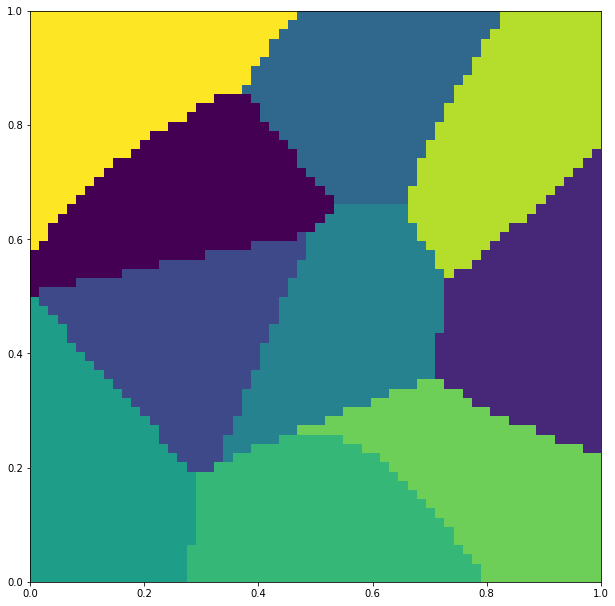

In [10]:
apd1.plot_apd()

In [11]:
# preparation
eps = 1e-4

In [12]:
Y = apd1.Y
II = apd1.assemble_apd()
II = II + 1
y = LazyTensor(Y.view(1, len(Y), 2))

In [13]:
apd1.set_W(W = torch.zeros(apd1.N))

In [14]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  149.73887634277344


In [15]:
D_ij = ((y - apd1.x) | apd1.a.matvecmult(y - apd1.x)) - apd1.w

In [16]:
D_ij.shape

(10, 3844)

In [17]:
proper_sumz = (-D_ij/eps).logsumexp(dim=0)
proper_sumz.shape

torch.Size([3844, 1])

In [18]:
def objective_function(X,A,W):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()

    a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
    w = LazyTensor(W.view(dims[0],1,1))
    x = LazyTensor(X.view(dims[0], 1, dims[1]))
    D_ij = ((y - x) | a.matvecmult(y - x)) - w
    second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    return -(first_sum - second_sum)

In [19]:
objective_function(apd1.X.contiguous(),apd1.As.contiguous(),apd1.W.contiguous())

tensor([985988.])

In [20]:
W_true

tensor([-0.0197,  0.0907, -0.0119, -0.0351,  0.0208, -0.1319,  0.1093,  0.1201,
         0.0136, -0.1560])

In [21]:
fun = lambda W : objective_function(apd1.X.contiguous(),apd1.As.contiguous(),W)

In [22]:
fun(apd1.W)

tensor([985988.])

In [23]:
fun(W_true)

tensor([10.5000])

In [24]:
gtol = 1e-12*torch.ones(len(apd1.W)).to(device=device)

In [25]:
solver = 'bfgs'
defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':1000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun, apd1.W, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 985988.0000
iter   1 - fval: 350304.0000
iter   2 - fval: 271900.0000
iter   3 - fval: 131465.7500
iter   4 - fval: 18532.2500
iter   5 - fval: 2672.7500
iter   6 - fval: 973.2500
iter   7 - fval: 329.0000
iter   8 - fval: 81.7500
iter   9 - fval: 21.7500
iter  10 - fval: 13.7500
iter  11 - fval: 11.7500
iter  12 - fval: 11.0000
iter  13 - fval: 10.2500
iter  14 - fval: 10.2500
Optimization terminated successfully.
         Current function value: 10.250000
         Iterations: 14
         Function evaluations: 23


In [33]:
W_approx = res.x

In [34]:
W_approx

tensor([-0.0197,  0.0906, -0.0119, -0.0352,  0.0209, -0.1318,  0.1093,  0.1202,
         0.0137, -0.1561])

In [35]:
W_true

tensor([-0.0197,  0.0907, -0.0119, -0.0351,  0.0208, -0.1319,  0.1093,  0.1201,
         0.0136, -0.1560])

(<Figure size 756x756 with 1 Axes>, <Axes: >)

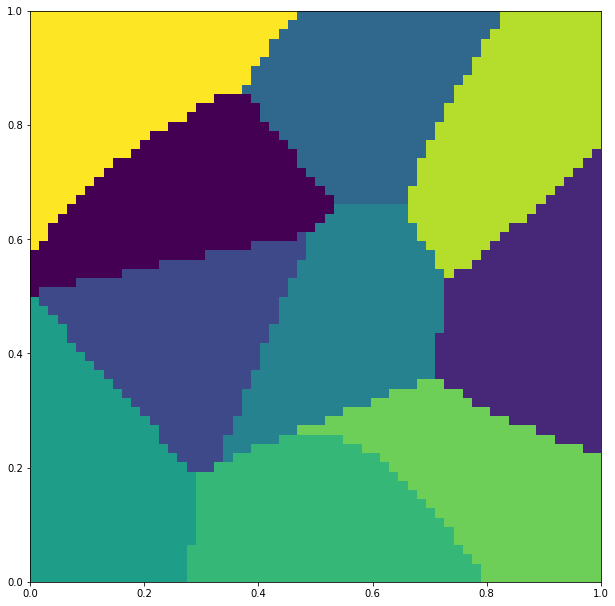

In [36]:
apd1.set_W(W = W_true)
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

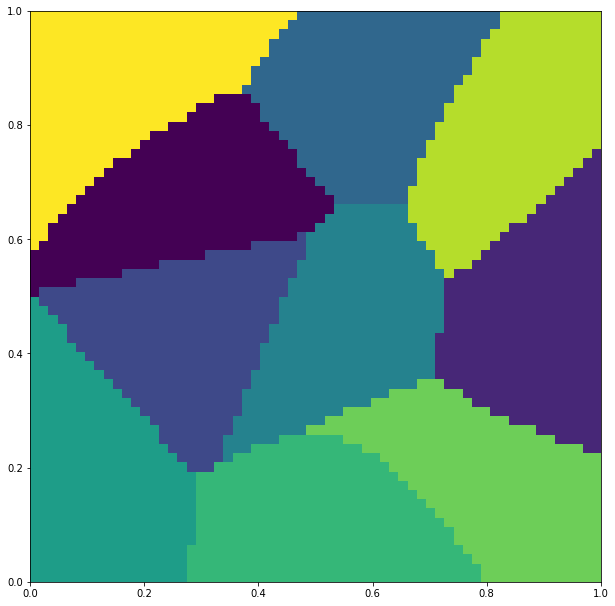

In [37]:
apd1.set_W(W = W_approx)
apd1.plot_apd()

In [38]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

difff / img_true.shape[0]

tensor(0.0003)

In [39]:
difff

tensor(1)